In [1]:
import os
import sys
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

from config import Config
from network import Network


# Configurations
testset_num = 5  # int(sys.argv[1]) if len(sys.argv) == 2 else 1
config = Config(testset_num=testset_num)
os.environ["CUDA_VISIBLE_DEVICES"] = config.GPUs

if not os.path.exists(config.save_dir):
    os.makedirs(config.save_dir)
print('save_dir:', config.save_dir)
cudnn.benchmark = True


# Data generator
from data import gen_paths_of_image, DataGen
image_paths = gen_paths_of_image(root_path='../datasets/PM2.5data/fog_1508_data')
TBVs = np.loadtxt('data_preparation/TBVs.txt').tolist()
entropies = np.loadtxt('data_preparation/entropies.txt').tolist()
pm = np.loadtxt('data_preparation/pm25.txt').tolist()

num_files = [0, 150, 90, 120, 151, 150, 120]

image_paths_test = image_paths[np.sum(num_files[:config.testset_num]):np.sum(num_files[:config.testset_num+1])]
TBVs_test = TBVs[np.sum(num_files[:config.testset_num]):np.sum(num_files[:config.testset_num+1])]
entropies_test = entropies[np.sum(num_files[:config.testset_num]):np.sum(num_files[:config.testset_num+1])]
pm_test = pm[np.sum(num_files[:config.testset_num]):np.sum(num_files[:config.testset_num+1])]

image_paths = image_paths[:np.sum(num_files[:config.testset_num])] + image_paths[np.sum(num_files[:config.testset_num+1]):]
TBVs = TBVs[:np.sum(num_files[:config.testset_num])] + TBVs[np.sum(num_files[:config.testset_num+1]):]
entropies = entropies[:np.sum(num_files[:config.testset_num])] + entropies[np.sum(num_files[:config.testset_num+1]):]
pm = pm[:np.sum(num_files[:config.testset_num])] + pm[np.sum(num_files[:config.testset_num+1]):]

method_on_TBV = 0
if method_on_TBV == 0:
    # Method-1 on TBVs
    TBV_min = np.min(TBVs)
    TBV_range = np.max(TBVs) - TBV_min
    entro_min = np.min(entropies)
    entro_range = np.max(entropies) - entro_min
    TBVs = (TBVs - TBV_min) / TBV_range
    entropies = (entropies - entro_min) / entro_range
    TBVs_test = (TBVs_test - TBV_min) / TBV_range
    entropies_test = (entropies_test - entro_min) / entro_range
elif method_on_TBV == 1:
    # Method-2 on TBVs
    TBVs = np.log(TBVs) * 1.
    TBVs_test = np.log(TBVs_test) * 1.

seed = 7
random.seed(seed); random.shuffle(image_paths)
random.seed(seed); random.shuffle(TBVs)
random.seed(seed); random.shuffle(entropies)
random.seed(seed); random.shuffle(pm)

gen_train = DataGen(image_paths, TBVs, entropies, pm, batch_size=config.batch_size)
gen_test = DataGen(image_paths_test, TBVs_test, entropies_test, pm_test, batch_size=config.batch_size_test)

print('Train Len', gen_train.data_len)
print('Test Len', gen_test.data_len)

save_dir: ../weights/PM2.5/weights_2019-09-11_testset5
Train Len 631
Test Len 150


In [ ]:
# Training
best_preds, best_MAPEs, best_MAPE_mean, best_path_weights = [1e6], [1e6], 1e6, 'zhengpeng'
model = Network(pretrain=True)
model = nn.DataParallel(model)
model = model.cuda()
criterion = torch.nn.MSELoss(reduction='sum').to(config.device)
optimizer = optim.Adam(model.parameters(), lr=config.lr, betas=(0.9, 0.999), weight_decay=config.weight_decay)
for epoch in range(config.epochs):
    gen_train = DataGen(image_paths, TBVs, entropies, pm, batch_size=config.batch_size, training=True)
    gen_test = DataGen(image_paths_test, TBVs_test, entropies_test, pm_test, batch_size=config.batch_size_test)
    losses_curr = []
    for idx_load in range(0, gen_train.data_len, gen_train.batch_size):
        model.train()
        batch_image, batch_TBV, batch_entropy, batch_pm = gen_train.gen_batch()
        pm_pred = model(
            torch.from_numpy(batch_image).float().cuda(),
            torch.from_numpy(batch_TBV).float().cuda(),
            torch.from_numpy(batch_entropy).float().cuda()
        )
        batch_TBV = np.squeeze(batch_TBV)
        batch_entropy = np.squeeze(batch_entropy)
        # with open('../preds.txt', 'a+') as fout:
        #     fout.write('{:.3f}, {:.3f}, {:.3f}, {:.3f}\n'.format(pm_pred[0].item(), batch_pm[0], batch_TBV[0], batch_entropy[0]))
        #     fout.write('{:.3f}, {:.3f}, {:.3f}, {:.3f}\n'.format(pm_pred[1].item(), batch_pm[1], batch_TBV[1], batch_entropy[1]))
        loss = criterion(pm_pred, torch.tensor(batch_pm).float().cuda().unsqueeze(-1))
        loss = loss.to(config.device)
        losses_curr.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Val
        if idx_load > 0 and 0 == (idx_load // gen_train.batch_size) % (gen_train.data_len // gen_train.batch_size // config.num_val_per_epoch):
            model.eval()
            pm_preds = []
            MAPEs = []
            for idx_load_test in range(0, gen_test.data_len, gen_test.batch_size):
                batch_image, batch_TBV, batch_entropy, batch_pm = gen_test.gen_batch()
                with torch.no_grad():
                    pm_pred = model(
                    torch.from_numpy(batch_image).float().cuda(),
                    torch.from_numpy(batch_TBV).float().cuda(),
                    torch.from_numpy(batch_entropy).float().cuda()
                ).squeeze().item()
                pm_preds.append(pm_pred)
                batch_pm = np.squeeze(batch_pm)
                MAPE = np.abs(pm_pred - batch_pm) * 100 / batch_pm
                MAPEs.append(MAPE)
            if np.mean(MAPEs) < best_MAPE_mean:
                best_preds = pm_preds
                best_MAPEs = MAPEs
                best_MAPE_mean = np.mean(best_MAPEs)
                best_dict_ckpt = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'loss': loss}
                best_path_ckpt = os.path.join(config.save_dir, 'PMNet_epoch{}_idxload{}_loss{:.1f}_MAPE{:.3f}.pth'.format(epoch+1, idx_load, loss, best_MAPE_mean))
                torch.save(best_dict_ckpt, best_path_ckpt)
            print('\tMAPE_mean = {:.3f}, best_MAPE_mean = {:.3f}'.format(np.mean(MAPEs), best_MAPE_mean))


    loss = np.mean(losses_curr)
    config.losses.append(loss)
    print('epoch={}, loss={}, time={}m'.format(epoch+1, loss, int((time.time()-config.time_st)/60)))

save_dir: ../results/PM2.5/results_2019-09-11_testset5


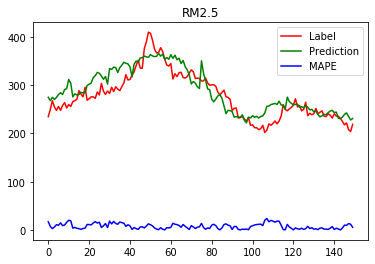

In [4]:
# Loss plot
if not os.path.exists(config.save_dir_test):
    os.makedirs(config.save_dir_test)
print('save_dir:', config.save_dir_test)
np.savetxt(os.path.join(config.save_dir_test, 'loss.txt'), config.losses)
plt.plot(config.losses)
plt.legend(['losses'])
plt.title('Loss')
plt.savefig(os.path.join(config.save_dir_test, 'loss_plot.png'))
plt.clf()

results = np.hstack([
    np.array(pm_test).reshape(-1, 1),
    np.array(best_preds).reshape(-1, 1),
    np.array(best_MAPEs).reshape(-1, 1)
])


path_results = best_path_ckpt.replace('weights', 'results').replace('PMNet', 'results').replace('.pth', '.csv')
pd.DataFrame(results).to_csv(path_results, index=False, header=['Label', 'Predictions', 'MAPE(%)'])

plt.plot(pm_test, 'r')
plt.plot(best_preds, 'g')
plt.plot(best_MAPEs, 'b')
plt.legend(['Label', 'Prediction', 'MAPE'])
plt.title('RM2.5')
plt.savefig(os.path.join(config.save_dir_test, 'results_plot.png'))